In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

Define Value object that can hold the mahematical expressions inside NNs

_operant = child of an operation, a set
_op the type of operation, a set
label is the label of a vlaue, nice for plotting
grad is initialized at 0 meaning no effect, will give the value of the gradient of the output wrt all children
backward is initalized as an empty function so that leaf nodes have no backpropagation 

Value does not have to have the definition of all possible operations as long as we know how to differentiate each part of the final expresion. 

In [24]:
class Value:

    def __init__(self,data, _operant=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_operant)
        self._op = _op
        self.label = label
    

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.gard
            other.grad = 1.0 * out.gard
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = [] # list of topologically ordered list of all nodes
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [10]:
a = Value(4, label='a')
b = Value(2, label='b')
c= Value(10, label='c')
e=a*b; e.label='e'
d = e+c; d.label = 'd'
f = Value(-2, label = 'f')
L = d*f; L.label='L'
L.grad = 1.0
L


0.0

In [11]:
# inputs x1,x2
x1 = Value(2.0,
label='x1')
x2 = Value (0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0,
label='w1')
w2 = Value(1.0,
label='w2')
# bias of the neuron
b = Value (6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1. label = 'x1*w1'
x2w2 = x2*w2; x2w2. label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n. label = 'n'
o = n. tanh(); o. label = 'o'

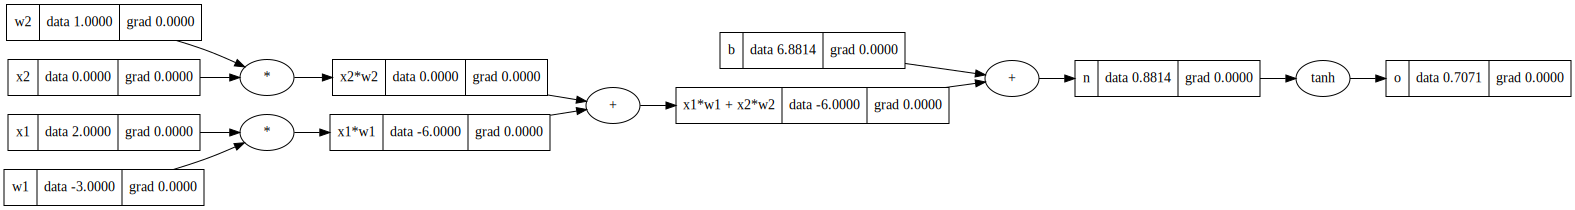

In [20]:
draw_dot(o)

In [25]:
o.backward()

AttributeError: 'Value' object has no attribute 'backward'

function to visualize the graph of an object

In [16]:
from graphviz import Digraph 

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build (child)
    build (root)
    return nodes, edges

def draw_dot (root):
    dot = Digraph (format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace (root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f|  grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge (uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

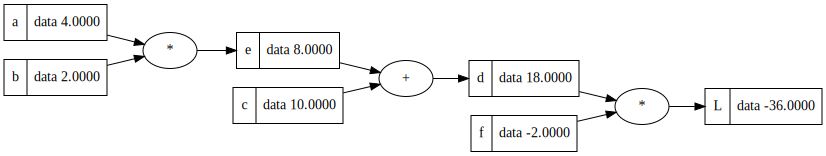

In [8]:
draw_dot(L)

Backpropagation 